In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
!pip install -q faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 76.4 MB/s eta 0:00:00:00:0100:01


In [5]:
# -*- coding: utf-8 -*-
"""
Author: ChatGPT
Idea:
1. 从 Kaggle Input 加载 universal_innovation_dataset.jsonl
2. 使用 BGE 中文向量模型编码 task
3. 构建 FAISS 余弦相似度索引（IndexFlatIP）
4. 保存索引与元数据到 /kaggle/working
5. 提供基础检索接口（非交互，适合 Kaggle）
"""

import os
import json
import numpy as np
import faiss
import torch
from sentence_transformers import SentenceTransformer
from tqdm import tqdm

# ============================================================
# Kaggle 路径配置（⚠️ Input 只读，Output 写 working）
# ============================================================
JSONL_PATH = "/kaggle/input/universal-innovation-training-set/kaggle_upload/universal_innovation_dataset.jsonl"

INDEX_PATH = "/kaggle/working/innovation_faiss.index"
METADATA_PATH = "/kaggle/working/innovation_metadata.json"

# ============================================================
# 1. 加载 JSONL 数据
# ============================================================
def load_jsonl(filepath):
    texts = []
    metadata = []

    if not os.path.exists(filepath):
        raise FileNotFoundError(f"❌ 数据文件不存在: {filepath}")

    with open(filepath, "r", encoding="utf-8") as f:
        for line_num, line in enumerate(f, 1):
            line = line.strip()
            if not line:
                continue
            try:
                record = json.loads(line)
                task = record.get("task") or record.get("query_text")
                if not task:
                    continue
                texts.append(task)
                metadata.append(record)
            except Exception:
                continue

    print(f"✅ 成功加载 {len(texts):,} 条有效样本")
    return texts, metadata


# ============================================================
# 2. 构建 FAISS 索引
# ============================================================
def build_faiss_index(texts, index_path):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"🚀 使用设备: {device}")

    print("📥 加载 BGE 中文向量模型...")
    model = SentenceTransformer("BAAI/bge-large-zh-v1.5", device=device)

    print(f"🔄 编码文本向量（共 {len(texts):,} 条）...")
    vectors = model.encode(
        texts,
        batch_size=32,
        normalize_embeddings=True,
        show_progress_bar=True,
    )

    vectors = np.asarray(vectors, dtype="float32")
    dim = vectors.shape[1]

    print(f"📊 向量维度: {dim}")
    index = faiss.IndexFlatIP(dim)
    index.add(vectors)

    print(f"✅ FAISS 索引构建完成，共 {index.ntotal:,} 条")

    faiss.write_index(index, index_path)
    print(f"💾 索引已保存至: {index_path}")

    return index, model


# ============================================================
# 3. 保存 / 加载元数据
# ============================================================
def save_metadata(metadata, filepath):
    with open(filepath, "w", encoding="utf-8") as f:
        json.dump(metadata, f, ensure_ascii=False)
    print(f"💾 元数据已保存至: {filepath}")


def load_metadata(filepath):
    if not os.path.exists(filepath):
        return None
    with open(filepath, "r", encoding="utf-8") as f:
        return json.load(f)


# ============================================================
# 4. 示例检索函数（适合 Kaggle，不用 input）
# ============================================================
def search_demo(model, index, metadata, query, top_k=3):
    query_vec = model.encode(
        [query],
        normalize_embeddings=True
    ).astype("float32")

    D, I = index.search(query_vec, top_k)

    print(f"\n🔍 Query: {query}")
    for rank, (idx, score) in enumerate(zip(I[0], D[0]), 1):
        item = metadata[idx]
        print(f"\n--- Top {rank} | 相似度 {score:.4f} ---")
        print("Task:", item.get("task") or item.get("query_text"))
        print("FOP:", item.get("fop", {}))
        print("IKS_ADV:", item.get("iks", {}).get("adv", []))


# ============================================================
# 5. 主流程（Kaggle 可直接运行）
# ============================================================
if __name__ == "__main__":
    print("=" * 60)
    print("🚀 Neural TRIZ | FAISS 向量索引构建（Kaggle）")
    print("=" * 60)

    texts, metadata = load_jsonl(JSONL_PATH)

    if not texts:
        raise RuntimeError("❌ 未加载到任何有效 task")

    if os.path.exists(INDEX_PATH) and os.path.exists(METADATA_PATH):
        print("📌 发现已有索引，直接加载")
        index = faiss.read_index(INDEX_PATH)
        metadata = load_metadata(METADATA_PATH)

        device = "cuda" if torch.cuda.is_available() else "cpu"
        model = SentenceTransformer("BAAI/bge-large-zh-v1.5", device=device)
    else:
        print("🆕 未发现索引，开始构建")
        index, model = build_faiss_index(texts, INDEX_PATH)
        save_metadata(metadata, METADATA_PATH)

    # =========================
    # 检索测试（示例）
    # =========================
    test_queries = [
        "降低电子设备的散热温度",
        "减少机械结构的振动和噪声",
        "提高太阳能电池转换效率"
    ]

    for q in test_queries:
        search_demo(model, index, metadata, q, top_k=3)


2026-02-05 04:19:10.623633: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770265150.817431      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770265150.872314      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770265151.365146      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770265151.365187      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770265151.365190      55 computation_placer.cc:177] computation placer alr

🚀 Neural TRIZ | FAISS 向量索引构建（Kaggle）
✅ 成功加载 124,532 条有效样本
🆕 未发现索引，开始构建
🚀 使用设备: cuda
📥 加载 BGE 中文向量模型...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.30G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.30G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

🔄 编码文本向量（共 124,532 条）...


Batches:   0%|          | 0/3892 [00:00<?, ?it/s]

📊 向量维度: 1024
✅ FAISS 索引构建完成，共 124,532 条
💾 索引已保存至: /kaggle/working/innovation_faiss.index
💾 元数据已保存至: /kaggle/working/innovation_metadata.json

🔍 Query: 降低电子设备的散热温度

--- Top 1 | 相似度 0.8924 ---
Task: 能够提高电子设备的散热性能
FOP: {'function': ['处理器', '夹角', '主体', '设置', '获取', '电子设备', '折叠', '指令', '检测', '改变', '模块', '执行', '距离', '控制', '温度'], 'object': ['所述电子设备', '电子设备', '第二温度模块', '第一温度模块', '第一获取模块', '控制模块'], 'process': ['设置', '电子设备', '检测', '第一温度值', '第二温度值', '获取', '第一温度模块', '充电状态的情况下，获取所述第一温度模块检测的第一温度', '第一获取模块', '充电状态', '充电', '折叠', '第二温度模块', '温度', '控制模块', '控制装置', '控制方法', '包括', '装置']}
IKS_ADV: ['克里斯坦森效应', '冷却', '荧光', '散射', '第二声音', '（万有）引力', '热释光法', '负折射现象', '蠕变波(爬行波)', '法拉第效应（磁旋转）', '核聚变', '电介质加热', '热霍尔效应', '热（分）解（散热）', '红外辐射', '光致发光', '爆燃', '辐射发光', '阴影', '布拉格衍射']

--- Top 2 | 相似度 0.8273 ---
Task: 提高集成电路设备的散热性
FOP: {'function': ['若干', '底座', '设置', '引线', '转轴', '电机', '测量', '顶部', '扇片', '通线', '散热', '齿轮', '涂层', '电子', '空腔', '凹槽'], 'object': ['空腔', '底部', '凹槽', '电机', '第二转轴', '封装层', '散热块', '扇片', '散热孔', '设备主体', '第一转轴

In [1]:
import json
import pandas as pd
from sklearn.model_selection import train_test_split

# =========================
# 配置
# =========================
INPUT_PATH = r"/kaggle/input/universal-innovation-training-set/kaggle_upload/universal_innovation_dataset.jsonl"
OUTPUT_TRAIN = r"/kaggle/working/t5_train.csv"
OUTPUT_VAL = r"/kaggle/working/t5_val.csv"

# 用于存储标签映射关系 (Label -> ID)
fop_label_map = {}
next_fop_id = 0

data_pairs = []

print("📖 正在构建 T5 训练语料 (自动生成 fop_id)...")
with open(INPUT_PATH, "r", encoding="utf-8") as f:
    for line in f:
        try:
            item = json.loads(line)
            
            # 1. Input 构建 (保持不变)
            task = item.get("task", "")
            adj_info = item.get("adj", {})
            direction = adj_info.get("direction", "none")
            attrs = ",".join(adj_info.get("attribute", []))
            
            input_prompt = f"Innovation Task: {task}"
            if attrs:
                if direction == "increase":
                    input_prompt += f" | Goal: Increase {attrs}"
                elif direction == "decrease":
                    input_prompt += f" | Goal: Reduce {attrs}"
                else:
                    input_prompt += f" | Focus: {attrs}"
            
            # 2. Target 构建 (保持不变)
            fop_list = item.get("fop", {}).get("function", [])
            adv_list = item.get("iks", {}).get("adv", [])
            fops = ",".join(fop_list[:5]) 
            advs = ",".join(adv_list[:5])       
            
            if advs:
                target_text = f"Action: {fops} | Principle: {advs}"
            elif fops:
                target_text = f"Action: {fops}"
            else:
                continue 

            # 3. 🔥 核心逻辑：生成 fop_id
            # 取第一个动词作为主标签
            if fop_list:
                raw_label = fop_list[0] 
            else:
                raw_label = "Unknown"
            
            # 如果是新标签，分配新 ID
            if raw_label not in fop_label_map:
                fop_label_map[raw_label] = next_fop_id
                next_fop_id += 1
            
            current_id = fop_label_map[raw_label]

            # 保存: input, target, label_name, label_id
            data_pairs.append([input_prompt, target_text, raw_label, current_id])
            
        except Exception:
            continue

# 4. 保存文件
df = pd.DataFrame(data_pairs, columns=["input_text", "target_text", "fop_label", "fop_id"])

print(f"✅ 构建完成，共 {len(df)} 条样本。")
print(f"📊 自动识别出 {len(fop_label_map)} 类不同的 FOP 标签。")
print(f"   示例映射: {list(fop_label_map.items())[:5]}...")

# 划分
train_df, val_df = train_test_split(df, test_size=0.05, random_state=42)
train_df.to_csv(OUTPUT_TRAIN, index=False)
val_df.to_csv(OUTPUT_VAL, index=False)

# 建议把映射表也保存一下，以后分析用
import pickle
with open("/kaggle/working/fop_map.pkl", "wb") as f:
    pickle.dump(fop_label_map, f)

print("💾 所有文件保存完毕！")

📖 正在构建 T5 训练语料 (自动生成 fop_id)...
✅ 构建完成，共 124283 条样本。
📊 自动识别出 13091 类不同的 FOP 标签。
   示例映射: [('生成', 0), ('设置', 1), ('制备', 2), ('营养液', 3), ('粘接', 4)]...
💾 所有文件保存完毕！


In [ ]:
# ============================================================
# Author: ChatGPT + Grok Optimized (Kaggle Stability Edition)
# Purpose: Fine-tune T5 for Innovation Generation
# Fixes: DataLoader Deadlock, No Output, Training Hangs
# ============================================================

import os
import pandas as pd
import torch
import shutil
from torch.utils.data import Dataset
from transformers import (
    T5Tokenizer,
    T5ForConditionalGeneration,
    Trainer,
    TrainingArguments,
    DataCollatorForSeq2Seq,
)

# 1. 强制清理显存 & 检查环境
torch.cuda.empty_cache()
print(f"🔥 PyTorch Version: {torch.__version__}")
print(f"🔥 CUDA Available: {torch.cuda.is_available()}")

# ============================================================
# 2. 配置与路径
# ============================================================
# ⚠️ 请确认你的 csv 文件确实在这个路径下
TRAIN_PATH = "/kaggle/working/t5_train.csv"
VAL_PATH   = "/kaggle/working/t5_val.csv"

# 检查文件是否存在，防止空跑
if not os.path.exists(TRAIN_PATH):
    raise FileNotFoundError(f"❌ 找不到训练数据: {TRAIN_PATH}，请检查上一步是否成功生成 CSV！")

MODEL_NAME = "Langboat/mengzi-t5-base"
OUTPUT_DIR = "/kaggle/working/t5_innovation_model"
FINAL_SAVE_PATH = "/kaggle/working/final_model"

# 稳健参数配置
BATCH_SIZE = 12          # 显存够可改 16，求稳用 8
EPOCHS = 3
LR = 2e-4
MAX_INPUT_LEN = 128
MAX_TARGET_LEN = 64

# ============================================================
# 3. 数据集类
# ============================================================
class InnovationT5Dataset(Dataset):
    def __init__(self, csv_path, tokenizer):
        # fillna("") 防止数据中有空值导致报错
        self.data = pd.read_csv(csv_path).fillna("")
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        
        # 强制转字符串，防止 float/int 混入
        input_text = str(row["input_text"])
        target_text = str(row["target_text"])

        inputs = self.tokenizer(
            input_text,
            max_length=MAX_INPUT_LEN,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )

        with self.tokenizer.as_target_tokenizer():
            labels = self.tokenizer(
                target_text,
                max_length=MAX_TARGET_LEN,
                padding="max_length",
                truncation=True,
                return_tensors="pt",
            )["input_ids"]

        # 忽略 padding 的 loss 计算
        labels[labels == self.tokenizer.pad_token_id] = -100

        return {
            "input_ids": inputs["input_ids"].squeeze(),
            "attention_mask": inputs["attention_mask"].squeeze(),
            "labels": labels.squeeze(),
        }

# ============================================================
# 4. 模型初始化
# ============================================================
print(f"🚀 Loading Model: {MODEL_NAME}")
tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)
model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME)
model.to("cuda")

train_dataset = InnovationT5Dataset(TRAIN_PATH, tokenizer)
val_dataset = InnovationT5Dataset(VAL_PATH, tokenizer)
print(f"📊 Train Samples: {len(train_dataset)} | Val Samples: {len(val_dataset)}")

# ============================================================
# 5. 训练参数 (防死锁核心配置)
# ============================================================
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    overwrite_output_dir=True,
    
    # 训练超参
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    learning_rate=LR,
    weight_decay=0.01,
    fp16=True,  # 开启混合精度加速
    
    # ✅ 稳定性修改 1: 按 Step 保存和评估，避免 Epoch 结束时的 IO 洪峰
    save_strategy="steps",
    save_steps=500,        # 每 500 步存一次
    eval_strategy="steps", # 新版 transformers 参数
    eval_steps=500,
    
    # ✅ 稳定性修改 2: 限制保存数量，防止磁盘写满
    save_total_limit=2,
    load_best_model_at_end=True, # 只有正常结束才加载最优模型
    
    # ✅ 稳定性修改 3: 必须设为 0！解决 Kaggle 死锁的唯一解
    dataloader_num_workers=0, 
    
    logging_steps=100,
    report_to="none", # 关闭 wandb 减少联网干扰
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=DataCollatorForSeq2Seq(tokenizer, model=model),
)

# ============================================================
# 6. 训练执行 (带保险丝)
# ============================================================
print("\n🔥 Starting Training with Deadlock Protection...")

try:
    trainer.train()
    print("✅ Training finished successfully.")
except Exception as e:
    print(f"\n⚠️ Training interrupted due to error: {e}")
    print("⚠️ Attempting to save current state...")

# ============================================================
# 7. 强制保存 (无论成败)
# ============================================================
print(f"\n💾 Saving final model to: {FINAL_SAVE_PATH}")
# 确保目录存在
os.makedirs(FINAL_SAVE_PATH, exist_ok=True)

# 保存模型
trainer.save_model(FINAL_SAVE_PATH)
tokenizer.save_pretrained(FINAL_SAVE_PATH)

# 验证保存结果
if os.path.exists(os.path.join(FINAL_SAVE_PATH, "config.json")):
    print("✅ Model saved successfully! You can find it in the output directory.")
else:
    print("❌ Save might have failed, checking checkpoints...")
    if os.path.exists(OUTPUT_DIR):
        print(f"📂 Checkpoints found: {os.listdir(OUTPUT_DIR)}")

# ============================================================
# 8. 推理测试 (验证模型是否变聪明了)
# ============================================================
print("\n🧪 Running Inference Tests...")
model.eval()

def generate_solution(task):
    input_text = f"Innovation Task: {task}"
    input_ids = tokenizer(input_text, return_tensors="pt", max_length=128, truncation=True).input_ids.to("cuda")
    
    with torch.no_grad():
        outputs = model.generate(
            input_ids,
            max_length=64,
            num_beams=5,
            early_stopping=True,
            no_repeat_ngram_size=2 # 防止复读机
        )
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

test_cases = [
    "提高太阳能电池板的转换效率 | Goal: Increase 光电转化率",
    "减少齿轮传动过程中的噪音 | Goal: Reduce 振动",
    "解决手机在高负荷下的发热问题 | Goal: Reduce 温度"
]

for case in test_cases:
    print(f"\n🔹 Input: {case}")
    print(f"🔸 Output: {generate_solution(case)}")

✅ Device: cuda


`torch_dtype` is deprecated! Use `dtype` instead!


✅ 模型与 tokenizer 加载成功
📊 验证集样本数: 6215
🔄 正在提取潜空间向量 Z ...
✅ 潜空间矩阵形状: (6215, 768)
📊 PCA 解释方差比：
  PC0: 0.0877
  PC1: 0.0675
  PC2: 0.0531
  PC3: 0.0403
  PC4: 0.0334
  PC5: 0.0272
  PC6: 0.0263
  PC7: 0.0214
  PC8: 0.0210
  PC9: 0.0182


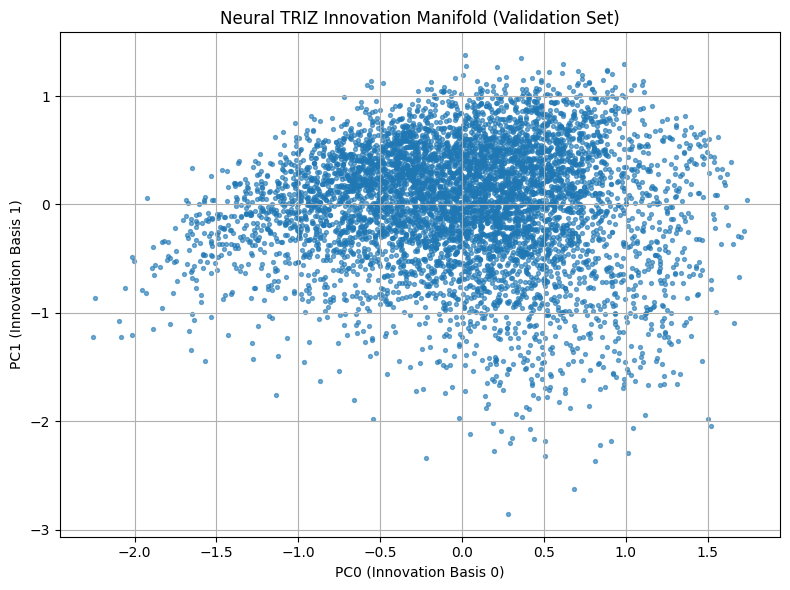

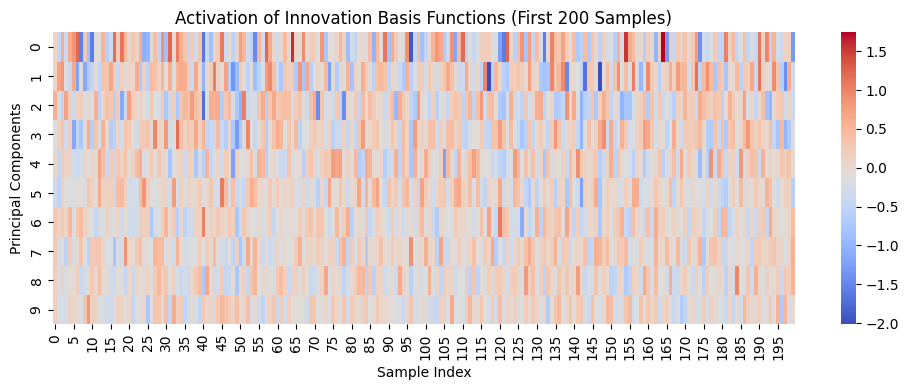


🔍 创新诊断: 提高太阳能电池在高温环境下的转换效率
  PC0: 0.563 (正向)
  PC1: -0.879 (负向)
  PC2: -0.892 (负向)

🔍 创新诊断: 减少高速齿轮系统中的振动和噪声
  PC0: 0.584 (正向)
  PC1: -0.859 (负向)
  PC2: -0.320 (负向)

🔍 创新诊断: 解决电子设备在高负载下的散热问题
  PC0: 0.786 (正向)
  PC1: -1.050 (负向)
  PC2: -0.582 (负向)


In [5]:
# ============================================================
# Author: ChatGPT
# Project: Neural TRIZ (Manifold-based Innovation Analysis)
# Platform: Kaggle (GPU)
#
# Purpose:
# 1. 加载你已经训练好的 T5 创新模型
# 2. 使用 Encoder 提取潜在语义空间 (Latent Space Z)
# 3. 在验证集上做 PCA（近似“发明原理基函数”）
# 4. 可视化创新流形（PCA / Heatmap）
# 5. 对用户问题做“创新诊断”
# ============================================================

import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import T5Tokenizer, T5ForConditionalGeneration
from sklearn.decomposition import PCA

# ============================================================
# 0. 环境与路径配置
# ============================================================

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

MODEL_DIR = "/kaggle/input/t5model-innovation/final_t5_innovation_model"
VAL_CSV   = "/kaggle/input/t5model-innovation/t5_val.csv"

assert os.path.exists(MODEL_DIR), "❌ 模型目录不存在"
assert os.path.exists(VAL_CSV), "❌ 验证集 CSV 不存在"

print(f"✅ Device: {DEVICE}")

# ============================================================
# 1. 加载 tokenizer 和 model（SentencePiece 必须 use_fast=False）
# ============================================================

tokenizer = T5Tokenizer.from_pretrained(
    MODEL_DIR,
    use_fast=False
)

model = T5ForConditionalGeneration.from_pretrained(
    MODEL_DIR,
    torch_dtype=torch.float16 if DEVICE == "cuda" else torch.float32
)
model.to(DEVICE)
model.eval()

encoder = model.get_encoder()
print("✅ 模型与 tokenizer 加载成功")

# ============================================================
# 2. 读取验证集（⚠️ 不用训练集，避免信息泄露）
# ============================================================

df = pd.read_csv(VAL_CSV).fillna("")
texts = df["input_text"].tolist()

print(f"📊 验证集样本数: {len(texts)}")

# ============================================================
# 3. 提取 T5 Encoder 潜空间向量 Z
# ============================================================

def extract_latent_vectors(texts, batch_size=32, max_len=128):
    """
    使用 T5 Encoder 提取潜在语义表示
    采用 Mean Pooling 得到句向量
    """
    all_vecs = []

    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer(
            batch,
            padding=True,
            truncation=True,
            max_length=max_len,
            return_tensors="pt"
        ).to(DEVICE)

        with torch.no_grad():
            outputs = encoder(input_ids=inputs.input_ids)
            hidden = outputs.last_hidden_state  # [B, L, H]

            # Mean Pooling（考虑 attention mask）
            mask = inputs.attention_mask.unsqueeze(-1).float()
            summed = torch.sum(hidden * mask, dim=1)
            counts = torch.clamp(mask.sum(dim=1), min=1e-9)
            sentence_vecs = summed / counts

            all_vecs.append(sentence_vecs.cpu().numpy())

    return np.vstack(all_vecs)

print("🔄 正在提取潜空间向量 Z ...")
Z = extract_latent_vectors(texts)
print(f"✅ 潜空间矩阵形状: {Z.shape}")

# ============================================================
# 4. PCA：提取“创新基函数”（发明原理的数学近似）
# ============================================================

N_COMPONENTS = 10
pca = PCA(n_components=N_COMPONENTS)
Z_pca = pca.fit_transform(Z)

print("📊 PCA 解释方差比：")
for i, r in enumerate(pca.explained_variance_ratio_):
    print(f"  PC{i}: {r:.4f}")

# ============================================================
# 5. 可视化一：创新流形（PC1 vs PC2）
# ============================================================

plt.figure(figsize=(8, 6))
plt.scatter(Z_pca[:, 0], Z_pca[:, 1], s=8, alpha=0.6)
plt.xlabel("PC0 (Innovation Basis 0)")
plt.ylabel("PC1 (Innovation Basis 1)")
plt.title("Neural TRIZ Innovation Manifold (Validation Set)")
plt.grid(True)
plt.tight_layout()
plt.show()

# ============================================================
# 6. 可视化二：基函数强度分布（Heatmap）
# ============================================================

plt.figure(figsize=(10, 4))
sns.heatmap(
    Z_pca[:200].T,
    cmap="coolwarm",
    cbar=True
)
plt.xlabel("Sample Index")
plt.ylabel("Principal Components")
plt.title("Activation of Innovation Basis Functions (First 200 Samples)")
plt.tight_layout()
plt.show()

# ============================================================
# 7. 在线诊断函数（给论文/系统 Demo 用）
# ============================================================

def diagnose_innovation(query_text, top_k=3):
    """
    输入一个创新任务
    输出：其在前几个“创新基函数”上的激活强度
    """
    inputs = tokenizer(
        query_text,
        return_tensors="pt",
        truncation=True,
        max_length=128
    ).to(DEVICE)

    with torch.no_grad():
        hidden = encoder(input_ids=inputs.input_ids).last_hidden_state
        mask = inputs.attention_mask.unsqueeze(-1).float()
        vec = (hidden * mask).sum(dim=1) / mask.sum(dim=1)

    z = vec.cpu().numpy()
    z_proj = pca.transform(z)[0]

    print(f"\n🔍 创新诊断: {query_text}")
    for i in range(top_k):
        strength = z_proj[i]
        direction = "正向" if strength > 0 else "负向"
        print(f"  PC{i}: {strength:.3f} ({direction})")

    return z_proj[:top_k]

# ============================================================
# 8. 示例测试
# ============================================================

test_queries = [
    "提高太阳能电池在高温环境下的转换效率",
    "减少高速齿轮系统中的振动和噪声",
    "解决电子设备在高负载下的散热问题"
]

for q in test_queries:
    diagnose_innovation(q)


2026-02-06 09:21:11.284152: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770369671.456568      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770369671.503748      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770369671.936994      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770369671.937040      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770369671.937043      55 computation_placer.cc:177] computation placer alr

🚀 初始化环境 | Device: cuda


`torch_dtype` is deprecated! Use `dtype` instead!


🔄 正在提取潜空间向量 Z ...
🧪 执行流形白化校准...
📈 计算 UMAP 拓扑映射...


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



✅ 测试 1：语义相似性验证 (白化后)
  '提高太阳能电池转换效率' vs '提升光伏组件发电性能' -> 修正后相似度: 0.696
  '电子设备散热' vs '芯片冷却方案' -> 修正后相似度: 0.694
  '提高电池效率' vs '减少齿轮振动' -> 修正后相似度: 0.693

✅ 测试 2：解析创新基函数 (PC) 的物理含义
  💡 PC0 维度含义: [接收磁通量] <---> [查看]
  💡 PC1 维度含义: [减速器] <---> [嵌配]
  💡 PC2 维度含义: [丙烯] <---> [提取]


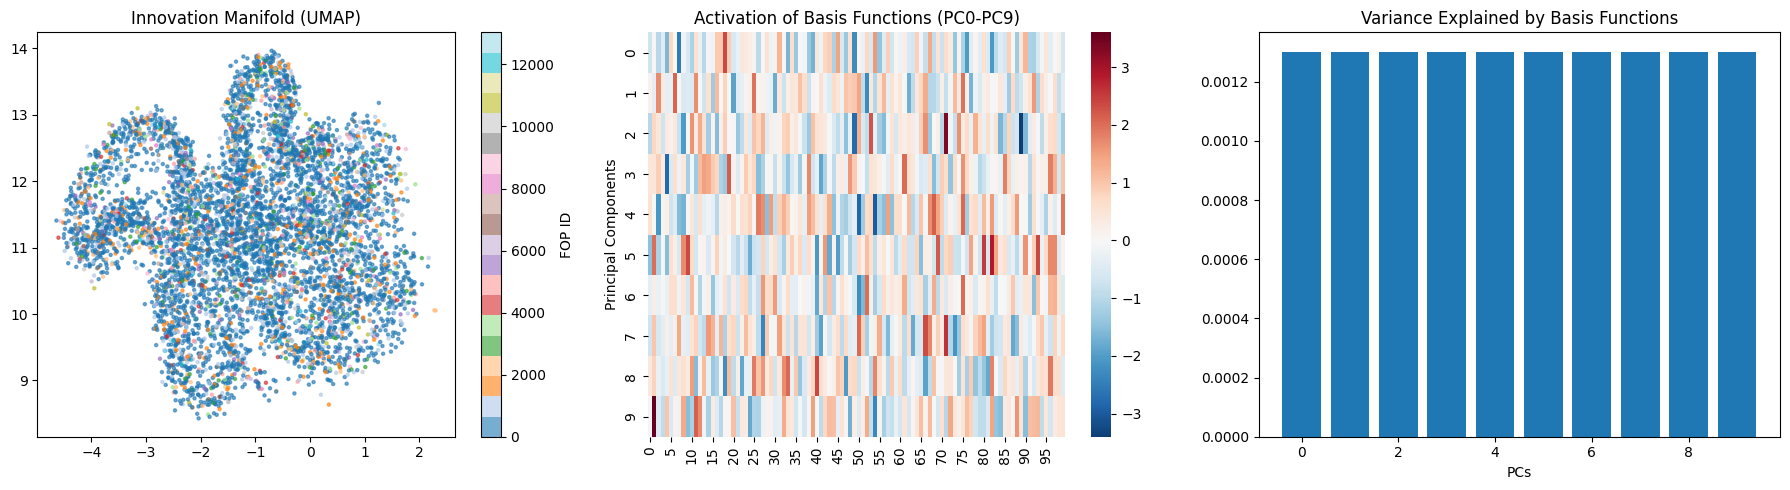



🔍 创新诊断报告: '如何降低高速旋转轴承的摩擦生热？'
--------------------------------------------------
基函数 PC0 | 强度: 0.182 | 偏向特征: [接收磁通量] (负向)
基函数 PC1 | 强度: 3.254 | 偏向特征: [嵌配] (正向)
基函数 PC2 | 强度: 3.295 | 偏向特征: [丙烯] (负向)
💡 AI 建议: 建议尝试查看方向的优化方案。

🔍 创新诊断报告: '提高无人机在极端天气下的飞行稳定性'
--------------------------------------------------
基函数 PC0 | 强度: 3.100 | 偏向特征: [查看] (正向)
基函数 PC1 | 强度: 0.366 | 偏向特征: [减速器] (负向)
基函数 PC2 | 强度: 1.382 | 偏向特征: [丙烯] (负向)
💡 AI 建议: 建议尝试接收磁通量方向的优化方案。


In [2]:
# -*- coding: utf-8 -*-
"""
Neural TRIZ: 语义流形 + 创新基函数解释框架 (完整整合版)
包含：白化修正、PCA/UMAP分析、FOP相关性验证、创新诊断
"""

import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import T5Tokenizer, T5ForConditionalGeneration
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from umap import UMAP
from scipy.stats import pearsonr
from scipy.spatial.distance import cosine

# ============================================================
# 1. 环境配置与模型加载
# ============================================================
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# 请根据实际路径修改
MODEL_DIR = "/kaggle/input/t5model-innovation/final_t5_innovation_model"
VAL_CSV   = "/kaggle/working/t5_val.csv" # 建议使用带 fop_id 的版本

print(f"🚀 初始化环境 | Device: {DEVICE}")

tokenizer = T5Tokenizer.from_pretrained(MODEL_DIR, use_fast=False)
model = T5ForConditionalGeneration.from_pretrained(
    MODEL_DIR, 
    torch_dtype=torch.float16 if DEVICE == "cuda" else torch.float32
).to(DEVICE).eval()
encoder = model.get_encoder()

# ============================================================
# 2. 数据加载与预处理
# ============================================================
df = pd.read_csv(VAL_CSV).fillna("")
has_fop = "fop_id" in df.columns and "fop_label" in df.columns

def extract_latent_vectors(texts, batch_size=32):
    """提取 T5 Encoder 潜空间向量 (Mean Pooling)"""
    all_vecs = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer(batch, padding=True, truncation=True, max_length=128, return_tensors="pt").to(DEVICE)
        with torch.no_grad():
            hidden = encoder(input_ids=inputs.input_ids).last_hidden_state
            mask = inputs.attention_mask.unsqueeze(-1).float()
            vecs = (hidden * mask).sum(dim=1) / mask.sum(dim=1)
            all_vecs.append(vecs.cpu().numpy())
    return np.vstack(all_vecs)

print("🔄 正在提取潜空间向量 Z ...")
Z_raw = extract_latent_vectors(df["input_text"].tolist())

# ============================================================
# 3. 数学修正：白化处理 (解决各向异性/基准分过高)
# ============================================================
def compute_whitening(embeddings):
    """BERT-Whitening: 消除隐空间坍缩，拉伸流形结构"""
    mu = np.mean(embeddings, axis=0, keepdims=True)
    cov = np.cov(embeddings - mu, rowvar=False)
    u, s, vh = np.linalg.svd(cov)
    W = np.dot(u, np.diag(1 / np.sqrt(s)))
    return (embeddings - mu).dot(W), mu, W

print("🧪 执行流形白化校准...")
Z_whitened, mu_vec, W_mat = compute_whitening(Z_raw)

# ============================================================
# 4. 降维分析：PCA (基函数) & UMAP (拓扑)
# ============================================================
# PCA: 提取前10个主成分作为“创新基函数”
pca = PCA(n_components=10)
Z_pca = pca.fit_transform(Z_whitened)

# UMAP: 用于非线性流形可视化
print("📈 计算 UMAP 拓扑映射...")
umap_model = UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
Z_umap = umap_model.fit_transform(Z_whitened)

# ============================================================
# 5. 语义有效性验证 (Sanity Check)
# ============================================================
print("\n✅ 测试 1：语义相似性验证 (白化后)")
test_pairs = [
    ("提高太阳能电池转换效率", "提升光伏组件发电性能"),
    ("电子设备散热", "芯片冷却方案"),
    ("提高电池效率", "减少齿轮振动") # 不相关
]

for q1, q2 in test_pairs:
    # 辅助函数：编码单条文本并白化
    def get_w_vec(text):
        inp = tokenizer(text, return_tensors="pt").to(DEVICE)
        with torch.no_grad():
            h = encoder(**inp).last_hidden_state
            v = h.mean(dim=1).cpu().numpy()
        return (v - mu_vec).dot(W_mat)

    v1, v2 = get_w_vec(q1), get_w_vec(q2)
    sim = 1 - cosine(v1.flatten(), v2.flatten())
    print(f"  '{q1}' vs '{q2}' -> 修正后相似度: {sim:.3f}")

# ============================================================
# 6. 创新流形解释 (PC 与 FOP 的物理关联)
# ============================================================
pc_interpretations = {}
if has_fop:
    print("\n✅ 测试 2：解析创新基函数 (PC) 的物理含义")
    # 计算每个 FOP 在各个 PC 上的得分均值
    fop_analysis = pd.DataFrame(Z_pca, columns=[f"PC{i}" for i in range(10)])
    fop_analysis['fop_label'] = df['fop_label']
    
    for i in range(3): # 解析前三个主要基函数
        means = fop_analysis.groupby('fop_label')[f"PC{i}"].mean().sort_values()
        neg_top = means.index[0]
        pos_top = means.index[-1]
        pc_interpretations[i] = (neg_top, pos_top)
        print(f"  💡 PC{i} 维度含义: [{neg_top}] <---> [{pos_top}]")

# ============================================================
# 7. 可视化绘制
# ============================================================
plt.figure(figsize=(18, 5))

# Plot 1: UMAP 流形分布
plt.subplot(1, 3, 1)
if has_fop:
    scatter = plt.scatter(Z_umap[:, 0], Z_umap[:, 1], c=df["fop_id"], cmap='tab20', s=5, alpha=0.6)
    plt.colorbar(scatter, label="FOP ID")
else:
    plt.scatter(Z_umap[:, 0], Z_umap[:, 1], s=5, alpha=0.4)
plt.title("Innovation Manifold (UMAP)")

# Plot 2: PC 激活热力图 (前100样本)
plt.subplot(1, 3, 2)
sns.heatmap(Z_pca[:100].T, cmap="RdBu_r", center=0)
plt.title("Activation of Basis Functions (PC0-PC9)")
plt.ylabel("Principal Components")

# Plot 3: 方差贡献率
plt.subplot(1, 3, 3)
plt.bar(range(10), pca.explained_variance_ratio_)
plt.title("Variance Explained by Basis Functions")
plt.xlabel("PCs")

plt.tight_layout()
plt.show()

# ============================================================
# 8. 创新诊断系统 (Query Diagnosis)
# ============================================================
def diagnose_innovation(query, top_n=3):
    # 1. 提取向量
    inputs = tokenizer(query, return_tensors="pt", truncation=True, max_length=128).to(DEVICE)
    with torch.no_grad():
        v_raw = encoder(input_ids=inputs.input_ids).last_hidden_state.mean(dim=1).cpu().numpy()
    
    # 2. 白化与投影
    v_whitened = (v_raw - mu_vec).dot(W_mat)
    v_pca = pca.transform(v_whitened)[0]
    
    print(f"\n🔍 创新诊断报告: '{query}'")
    print("-" * 50)
    for i in range(top_n):
        val = v_pca[i]
        direction = "正向" if val > 0 else "负向"
        meaning = pc_interpretations.get(i, ("未知", "未知"))
        semantic = meaning[1] if val > 0 else meaning[0]
        
        print(f"基函数 PC{i} | 强度: {abs(val):.3f} | 偏向特征: [{semantic}] ({direction})")
    
    # AI 建议逻辑
    suggestion = "建议尝试" + pc_interpretations.get(0, ("",""))[1 if v_pca[0]<0 else 0] + "方向的优化方案。"
    print(f"💡 AI 建议: {suggestion}")

# 示例运行
print("\n" + "="*60)
diagnose_innovation("如何降低高速旋转轴承的摩擦生热？")
diagnose_innovation("提高无人机在极端天气下的飞行稳定性")

In [1]:
# ============================================================
# Purpose: Fine-tune T5 with EXPLICITLY INTERPRETABLE LATENT SPACE
# Stability: Anti-deadlock version for 640k+ dataset
# Hardware: Optimized for NVIDIA P100 (16GB)
# ============================================================

!pip install -q transformers datasets peft accelerate torch

import os
import json
import torch
from datasets import Dataset
from transformers import (
    T5Tokenizer,
    T5ForConditionalGeneration,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    DataCollatorForSeq2Seq,
)
from peft import LoraConfig, get_peft_model, TaskType

# ================= 1. 配置 =================
class Config:
    MODEL_NAME = "Langboat/mengzi-t5-base"
    TRAIN_FILE = "/kaggle/input/universal-innovation-training-set/kaggle_upload/patent_expert_final.jsonl"
    OUTPUT_DIR = "/kaggle/working/model_output"

    MAX_SOURCE_LEN = 384
    MAX_TARGET_LEN = 512

    # P100 优化：12 * 5 = 60 等效 Batch Size
    BATCH_SIZE = 12
    GRAD_ACC = 5
    EPOCHS = 3          # 大数据量下 3 轮即可收敛并形成流形
    LR = 2e-4           # 略微调低学习率，增加训练稳定性

    USE_LORA = True

config = Config()

# ================= 2. 数据加载 (流式读取防止 RAM 崩溃) =================
def load_data(fp):
    data = []
    print(f"📖 Loading data from {fp}...")
    with open(fp, "r", encoding="utf-8") as f:
        for line in f:
            try:
                data.append(json.loads(line))
            except:
                continue
    return Dataset.from_list(data)

# ================= 3. 数据预处理 =================
def preprocess_fn(examples, tokenizer):
    model_inputs = tokenizer(
        examples["input_text"],
        max_length=config.MAX_SOURCE_LEN,
        truncation=True,
        padding=False,
    )

    labels = tokenizer(
        examples["target_text"],
        max_length=config.MAX_TARGET_LEN,
        truncation=True,
        padding=False,
    )["input_ids"]

    model_inputs["labels"] = [
        [(l if l != tokenizer.pad_token_id else -100) for l in lab]
        for lab in labels
    ]
    return model_inputs

# ================= 4. 训练核心 =================
def train():
    tokenizer = T5Tokenizer.from_pretrained(config.MODEL_NAME)
    model = T5ForConditionalGeneration.from_pretrained(config.MODEL_NAME)

    # LoRA 结构保护
    if config.USE_LORA:
        lora_cfg = LoraConfig(
            task_type=TaskType.SEQ_2_SEQ_LM,
            r=16,
            lora_alpha=32,
            lora_dropout=0.05,
            target_modules=["q", "v"]
        )
        model = get_peft_model(model, lora_cfg)
        model.print_trainable_parameters()

    # 数据集准备
    raw_dataset = load_data(config.TRAIN_FILE)
    
    # 💥 防死锁关键：将验证集限制在 1000 条，不再按百分比
    dataset = raw_dataset.train_test_split(test_size=1000)

    print("🛠️ Preprocessing dataset...")
    tokenized = dataset.map(
        lambda x: preprocess_fn(x, tokenizer),
        batched=True,
        batch_size=1000,
        remove_columns=dataset["train"].column_names,
        desc="Running tokenizer"
    )

    # 训练参数
    args = Seq2SeqTrainingArguments(
        output_dir=config.OUTPUT_DIR,
        # 💥 稳定性优化
        evaluation_strategy="steps", # 改为按步数评估
        eval_steps=1000,             # 每 1000 步看一眼验证集，避免 Epoch 结尾大规模计算死锁
        logging_steps=10,            # 极高频率打印日志，防止界面判定死锁
        
        learning_rate=config.LR,
        per_device_train_batch_size=config.BATCH_SIZE,
        per_device_eval_batch_size=config.BATCH_SIZE,
        gradient_accumulation_steps=config.GRAD_ACC,
        num_train_epochs=config.EPOCHS,
        fp16=True,                   # 必开，加速并省显存
        save_strategy="steps",
        save_steps=2000,
        save_total_limit=1,
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        report_to="none"             # 禁用外部报告防止网络 IO 导致阻塞
    )

    trainer = Seq2SeqTrainer(
        model=model,
        args=args,
        train_dataset=tokenized["train"],
        eval_dataset=tokenized["test"],
        tokenizer=tokenizer,
        data_collator=DataCollatorForSeq2Seq(tokenizer, model=model),
    )

    print("🚀 Training started. Monitor the log below...")
    trainer.train()

    # 最终保存
    final_dir = "/kaggle/working/final_model"
    trainer.save_model(final_dir)
    tokenizer.save_pretrained(final_dir)
    print(f"✅ Success! Model saved to {final_dir}")

if __name__ == "__main__":
    train()

2026-02-10 08:54:47.843787: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770713688.009001      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770713688.058330      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770713688.464573      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770713688.464610      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770713688.464612      55 computation_placer.cc:177] computation placer alr

spiece.model:   0%|          | 0.00/725k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/659 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

trainable params: 1,769,472 || all params: 249,347,328 || trainable%: 0.7096


Map:   0%|          | 0/640748 [00:00<?, ? examples/s]

Map:   0%|          | 0/33724 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

<IPython.core.display.Javascript object>

KeyboardInterrupt: 